# Project2_Team 3_Analysis


## Import the necessary libraries/functions

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, countDistinct, split, reverse, hour, udf
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, DateType, FloatType, BooleanType


## Configure access to our Azure Storage account container:

In [0]:
contname = 'team3-project2' #azure storage account container
storage_acct_name = '20230821desa'
client_id = 'de4ff859-02b1-4e2f-9d16-b578fa03df4f' #aka: app id
tenant_id = '33da9f3f-4c1a-4640-8ce1-3f63024aea1d' #aka: directory id
service_credential = dbutils.secrets.get(scope="databricks-app-kv",key="databricks-application")


## Configure Spark to access Azure Storage securely using OAuth-based authentication:

In [0]:
spark.conf.set(f"fs.azure.account.auth.type.{storage_acct_name}.dfs.core.windows.net", "OAuth")
spark.conf.set(f"fs.azure.account.oauth.provider.type.{storage_acct_name}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")
spark.conf.set(f"fs.azure.account.oauth2.client.id.{storage_acct_name}.dfs.core.windows.net", f"{client_id}")
spark.conf.set(f"fs.azure.account.oauth2.client.secret.{storage_acct_name}.dfs.core.windows.net", service_credential)
spark.conf.set(f"fs.azure.account.oauth2.client.endpoint.{storage_acct_name}.dfs.core.windows.net", f"https://login.microsoftonline.com/{tenant_id}/oauth2/token")

## Read data from gold layer

In [0]:
Event_Table = spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/Event_Table/")
repo_df = spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/repo_df/")
actor_df = spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/actor_df/")
organization_df = spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/organization_df/")
PushEvent_df =  spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/PushEvent_df/")
ReleaseEvent_df = spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/ReleaseEvent_df/")
CommitCommentEvent_df = spark.read.parquet(f"abfss://{contname}@{storage_acct_name}.dfs.core.windows.net/GoldLayer/CommitCommentEvent_df/")

# Analysis
---

### 1 - Data aggregated by type of GitHub event per hour 

In [0]:
# group by type then hour, count, and sort by type and hour:
type_hour_grouped = Event_Table.groupBy("type",hour(col("created_at")).alias("hour")).agg({"*": "count"})\
    .withColumnRenamed("count(1)","count").orderBy("type","hour")
type_hour_grouped.display()

type,hour,count
CommitCommentEvent,0,17406
CommitCommentEvent,1,16568
CommitCommentEvent,2,16624
CommitCommentEvent,3,17059
CommitCommentEvent,4,16727
CommitCommentEvent,5,15976
CommitCommentEvent,6,17364
CommitCommentEvent,7,18541
CommitCommentEvent,8,20337
CommitCommentEvent,9,21523


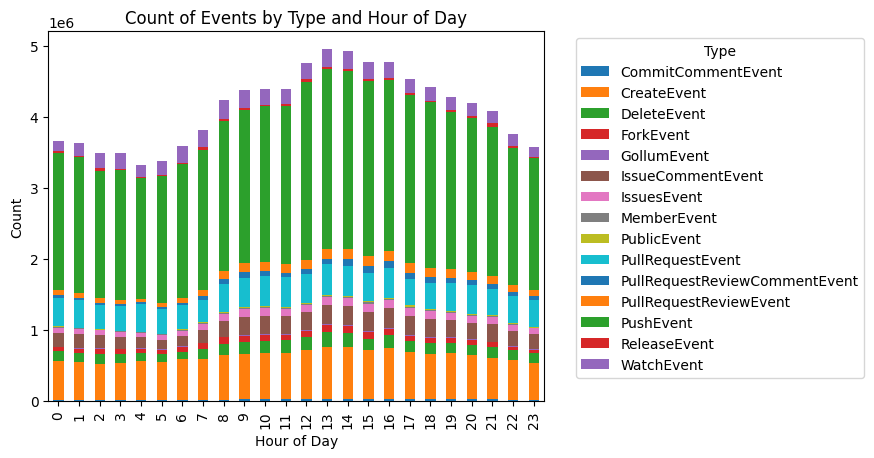

In [0]:
# Visualization for the results of the previous cell:

import matplotlib.pyplot as plt
import pandas as pd

# Convert the DataFrame to a Pandas DataFrame
type_hour_df = type_hour_grouped.toPandas()

# Create a pivot table for plotting
pivot_table = type_hour_df.pivot(index='hour', columns='type', values='count')

# Plot a bar chart
ax = pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Count of Events by Type and Hour of Day')

# Adjust the legend
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### 2 - PushEvent data aggregated by ref type – whether the commit is on the main branch 

In [0]:
# UDF to return true if ref is "main" and false if commit was on any branch other than "main"
def is_main_branch(ref_value):
    return ref_value == "main"

# Register the UDF
is_main_branch_udf = udf(is_main_branch, BooleanType())

# Apply the UDF
branch_grouped_main = PushEvent_df.withColumn("is_main_branch", is_main_branch_udf(PushEvent_df["ref"]))\
    .groupBy("is_main_branch")\
    .agg({"*": "count"})\
    .withColumnRenamed("count(1)", "count")
   
branch_grouped_main.show()

+--------------+--------+
|is_main_branch|   count|
+--------------+--------+
|          true|28751739|
|         false|46289253|
+--------------+--------+



### 3 - Breakdown of events by type and number of commits per event 

In [0]:
# We have the count of each event type as following:
Event_Table.groupBy("type").count().orderBy("count", ascending=False).display()

type,count
PushEvent,50895123
CreateEvent,14717172
PullRequestEvent,9311768
IssueCommentEvent,5328832
WatchEvent,4996749
DeleteEvent,3623692
PullRequestReviewEvent,2500358
IssuesEvent,2280108
ForkEvent,1773263
PullRequestReviewCommentEvent,1438337


In [0]:
# However, since not all of the above event dataframes had a "sha" or "commit_id" field in them in the original
# payload column (at least based on our exploaration) we are answering this question only for a dataframe which
# has a commit_id column: CommitCommentEvent_df.

unique_commits = CommitCommentEvent_df.select("commit_id").distinct().count()
print(f"There are {unique_commits} unique commits in CommitCommentEvent table")

There are 434570 unique commits in CommitCommentEvent table


### 4 - Breakdowns of user activity

In [0]:
# Create a pivot table to summarize event counts by actor_id and event types.
pivot_table = Event_Table.groupBy("actor_id").pivot("type").count()

In [0]:
pivot_table.persist()  # persist it in memory_and_disk
pivot_table = pivot_table.fillna(0)   # replace the retunrned nulls with a 0 count

In [0]:
# Join the pivot table with actor to obrain the user login column (leftmost column shown below)
actor_Event_joined = actor_df.join(pivot_table, "actor_id").drop("actor_id")
actor_Event_joined.display()
# Display for each user the count for each activity/event they were involved in.

login,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent
evanphx,0,2,2,0,0,23,2,0,0,6,11,25,9,1,0
macournoyer,0,0,0,0,0,6,1,0,0,0,7,14,0,0,0
caged,0,6,0,0,0,0,0,0,0,0,0,0,1,0,21
topfunky,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
tomtt,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0
nitay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
bs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
uggedal,0,1,0,1,0,0,0,0,0,1,0,0,5,0,0
tmornini,0,7,2,0,0,1,0,0,0,0,2,2,37,0,0
jm,0,0,0,1,0,0,0,0,0,0,0,0,14,0,0


In [0]:
pivot_table.unpersist()   # Unpersist once done.

### 5 - Our team's unique use case:
- #### Which orgs have the highest number of releases to production?

In [0]:
# This question require a three-way join between Event, org, and release tables:
Event_org_joined = Event_Table.repartition("org_id").join(organization_df, "org_id").select("event_id",col("login").alias("Organization"))
Event_org_release_joined = Event_org_joined.repartition("event_id").join(ReleaseEvent_df, "event_id")
Event_org_release_joined.persist()
Event_org_release_joined.limit(5).display()

event_id,Organization,release_id
19849808622,Oriflame,57678890
19944519173,Elogbooks-FM-Ltd,58090494
19739157454,AdvancedSoftwareDevelopment2021,57110730
19986862238,GooseMod,58289287
19884597818,voysys,57822696


In [0]:
# Group by organization to get a distinct count of release_id's:
organization_grouped = Event_org_release_joined.groupBy("Organization").agg(countDistinct("release_id").alias("release_count")).orderBy("release_count", ascending = False)
organization_grouped.limit(5).display()

# Top 5 organizations with highest number of releases to production:

Organization,release_count
conda-forge,25709
hmrc,3280
truecharts,2155
ursacomputing,2150
sprucelabsai,1921


In [0]:
Event_org_release_joined.unpersist()

DataFrame[event_id: string, Organization: string, release_id: bigint]